In [1443]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from datetime import timedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from numpy import NaN
import seaborn as sns

In [2001]:
CURRENT_LOCATION = "mgazza"

In [2002]:
path_to_file = 'APPA_data_merged.csv'
df = pd.read_csv(path_to_file, parse_dates=["Data"])
df_bolz_pm10 = df[(df.Stazione == "Monte Gaza") & (df.Inquinante == "Ozono")]

In [2003]:
station_list = df.Stazione.unique()
pollutants_per_station = {}
for st in station_list:
    pollutants_per_station[st] = df[df.Stazione == st].Inquinante.unique().tolist()

pollutants_per_station

{'A22 (Avio)': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10'],
 'Borgo Valsugana': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Monte Gaza': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Parco S. Chiara': ['Biossido Zolfo',
  'Biossido di Azoto',
  'Ozono',
  'PM10',
  'PM2.5'],
 'Piana Rotaliana': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Riva del Garda': ['Biossido di Azoto', 'Ozono', 'PM10'],
 'Rovereto': ['Biossido di Azoto', 'Ozono', 'PM10', 'PM2.5'],
 'Via Bolzano': ['Biossido di Azoto', 'Ossido di Carbonio', 'PM10']}

Makes the daily mean from the hour values

In [2004]:
df_daily = df_bolz_pm10.resample("D", on='Data').mean()
df_daily = df_daily.reset_index()

In [2005]:
df_daily.head()

,Data,Valore
0,2018-01-28,86.652174
1,2018-01-29,85.340426
2,2018-01-30,84.880000
3,2018-01-31,51.416667
4,2018-02-01,57.791667


In [2006]:
weather_file_path = "weather_data.csv"
weather_df = pd.read_csv(weather_file_path, parse_dates=["Data"])

In [2007]:
locations = list(set(weather_df.columns[1:].map(lambda x: x.split()[0])))
locations

['rg', 'bolz', 'parco', 'borgo', 'piana', 'avio', 'rov', 'mgazza']

In [2008]:
weather_loc = {}

for location in locations:
    location_columns = weather_df.columns[
        weather_df.columns.map(lambda x: x.split()[0] == location)
    ]

    location_df = weather_df[["Data"] + location_columns.tolist()]
    location_df.columns = location_df.columns.str.replace(location, "").str.strip()
    location_df["Location"] = location
    
    weather_loc[location] = location_df


C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df["Location"] = location
C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\2564517573.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [2009]:
df_weather_long = pd.concat(weather_loc.values())
# df_weather_long.to_csv("./weather_long_format.csv", index=None)

In [2010]:
merged_df = df_daily.join(
    df_weather_long[df_weather_long.Location == CURRENT_LOCATION].set_index("Data"), 
    on="Data"
)
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol
0,2018-01-28,86.652174,0.0,3.9,mgazza,61.5,315.0,1.6,862.0,8099.2
1,2018-01-29,85.340426,0.0,4.6,mgazza,62.9,323.0,1.7,859.7,8378.6
2,2018-01-30,84.880000,0.0,3.8,mgazza,52.1,337.0,1.9,855.4,8047.2
3,2018-01-31,51.416667,0.0,-1.1,mgazza,94.8,36.0,1.4,849.0,3827.5
4,2018-02-01,57.791667,8.4,0.0,mgazza,99.2,112.0,1.5,836.3,1231.6
...,...,...,...,...,...,...,...,...,...,...
1618,2022-07-04,125.333333,15.0,15.6,mgazza,86.3,304.0,1.0,855.0,15249.0
1619,2022-07-05,108.000000,1.4,16.5,mgazza,70.6,330.0,1.4,853.4,27700.7
1620,2022-07-06,117.666667,5.8,16.3,mgazza,66.3,195.0,1.4,854.9,27849.4
1621,2022-07-07,127.041667,2.0,14.7,mgazza,81.6,301.0,1.1,853.5,18904.4


In [2011]:
# add column for the value of the previous day
weather_parameters = ['rain', 'temp', 'press', 'hum', 'w_dir', 'w_sp', 'sol']
prev_day_values = {}
for par in weather_parameters:
    for i in range(1, 8):
        prev_day_values[f"{par} {i} day/s earlier"]  = []
        for date in merged_df["Data"]:
            prev_day = date - timedelta(hours=int(24 * i))
            series = merged_df[merged_df.Data == prev_day][par].values.tolist()
            #print(series)
            if len(series) > 0:
                value = series[0]
            else:
                value = NaN  # takes the current day, not the previous
            prev_day_values[f"{par} {i} day/s earlier"].append(value)

        merged_df[f"{par} {i} day/s earlier"] = prev_day_values[f'{par} {i} day/s earlier']

In [2012]:
merged_df = merged_df.dropna()

In [2013]:
merged_df.isna().sum()

Data                     0
Valore                   0
rain                     0
temp                     0
Location                 0
hum                      0
w_dir                    0
w_sp                     0
press                    0
sol                      0
rain 1 day/s earlier     0
rain 2 day/s earlier     0
rain 3 day/s earlier     0
rain 4 day/s earlier     0
rain 5 day/s earlier     0
rain 6 day/s earlier     0
rain 7 day/s earlier     0
temp 1 day/s earlier     0
temp 2 day/s earlier     0
temp 3 day/s earlier     0
temp 4 day/s earlier     0
temp 5 day/s earlier     0
temp 6 day/s earlier     0
temp 7 day/s earlier     0
press 1 day/s earlier    0
press 2 day/s earlier    0
press 3 day/s earlier    0
press 4 day/s earlier    0
press 5 day/s earlier    0
press 6 day/s earlier    0
press 7 day/s earlier    0
hum 1 day/s earlier      0
hum 2 day/s earlier      0
hum 3 day/s earlier      0
hum 4 day/s earlier      0
hum 5 day/s earlier      0
hum 6 day/s earlier      0
h

In [2014]:
#merged_df.corr()

In [2015]:
merged_df.describe()

,Valore,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,rain 2 day/s earlier,...,w_sp 5 day/s earlier,w_sp 6 day/s earlier,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier
count,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,...,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000
mean,97.505444,4.100375,6.475218,79.624407,243.778402,1.568602,849.001685,13275.164607,4.100375,4.099625,...,1.570787,1.571223,1.570350,13261.891823,13252.161798,13238.972909,13225.399064,13224.336454,13211.931773,13200.741698
std,21.785874,11.105037,6.695677,16.187096,117.720942,0.544847,6.993748,8027.727465,11.105037,11.105219,...,0.545902,0.545828,0.544292,8017.351736,8020.599300,8014.055340,8007.684894,8004.437127,7999.590629,7995.827405
min,43.260870,0.000000,-13.500000,23.300000,0.000000,0.000000,821.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.052083,0.000000,1.000000,68.900000,122.000000,1.200000,845.200000,6134.200000,0.000000,0.000000,...,1.200000,1.200000,1.200000,6115.425000,6115.425000,6115.425000,6107.550000,6115.425000,6115.425000,6115.425000
50%,92.625000,0.000000,6.200000,83.800000,312.000000,1.500000,850.300000,12401.450000,0.000000,0.000000,...,1.500000,1.500000,1.500000,12378.350000,12357.600000,12321.750000,12291.250000,12278.600000,12269.250000,12254.200000
75%,111.364583,1.600000,12.600000,92.600000,327.000000,1.800000,853.800000,20162.700000,1.600000,1.600000,...,1.800000,1.800000,1.800000,20140.350000,20140.350000,20118.700000,20096.200000,20096.200000,20063.600000,20053.875000
max,190.400000,116.600000,23.300000,100.000000,360.000000,5.900000,866.200000,30296.800000,116.600000,116.600000,...,5.900000,5.900000,5.900000,30296.800000,30296.800000,30296.800000,30296.800000,30296.800000,30296.800000,30296.800000


In [2016]:
merged_df = merged_df.dropna()
merged_df

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,w_sp 5 day/s earlier,w_sp 6 day/s earlier,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier
7,2018-02-04,77.083333,0.0,-6.9,mgazza,74.5,325.0,1.2,841.7,7418.2,...,1.9,1.7,1.6,4770.1,705.6,1231.6,3827.5,8047.2,8378.6,8099.2
8,2018-02-05,74.291667,0.0,-5.2,mgazza,95.6,122.0,0.8,848.1,4470.3,...,1.4,1.9,1.7,7418.2,4770.1,705.6,1231.6,3827.5,8047.2,8378.6
9,2018-02-06,82.833333,1.6,-3.9,mgazza,95.7,335.0,1.0,843.1,2988.2,...,1.5,1.4,1.9,4470.3,7418.2,4770.1,705.6,1231.6,3827.5,8047.2
10,2018-02-07,88.416667,3.6,-1.3,mgazza,96.1,61.0,0.9,836.9,4044.3,...,2.4,1.5,1.4,2988.2,4470.3,7418.2,4770.1,705.6,1231.6,3827.5
11,2018-02-08,74.083333,1.2,-1.0,mgazza,81.2,39.0,1.1,842.0,6058.0,...,3.1,2.4,1.5,4044.3,2988.2,4470.3,7418.2,4770.1,705.6,1231.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,2022-07-04,125.333333,15.0,15.6,mgazza,86.3,304.0,1.0,855.0,15249.0,...,1.4,1.7,1.8,26513.0,25016.6,23977.4,20882.2,17018.5,12265.9,22761.0
1619,2022-07-05,108.000000,1.4,16.5,mgazza,70.6,330.0,1.4,853.4,27700.7,...,1.2,1.4,1.7,15249.0,26513.0,25016.6,23977.4,20882.2,17018.5,12265.9
1620,2022-07-06,117.666667,5.8,16.3,mgazza,66.3,195.0,1.4,854.9,27849.4,...,1.7,1.2,1.4,27700.7,15249.0,26513.0,25016.6,23977.4,20882.2,17018.5
1621,2022-07-07,127.041667,2.0,14.7,mgazza,81.6,301.0,1.1,853.5,18904.4,...,1.4,1.7,1.2,27849.4,27700.7,15249.0,26513.0,25016.6,23977.4,20882.2


In [2017]:
from sklearn.model_selection import train_test_split

In [2018]:
input_columns = [
    'rain', 
    'temp', 
    'hum', 
    'w_dir', 
    'w_sp', 
    'press', 
    'sol'
]

for i in range (1, 8):
    for par in weather_parameters:
        input_columns.append(f"{par} {i} day/s earlier")

X = merged_df[input_columns]
y = merged_df['Valore']

In [2029]:
#test_years = [2015, 2017]
#train_years = [2012, 2013, 2014, 2016, 2018, 2019, 2020, 2021, 2022]

test_years = [2019]
train_years = [2018, 2020, 2021, 2022]


In [2030]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=SEED)

In [2031]:
X_train, y_train, X_test, y_test = (
    X[merged_df.Data.dt.year.isin(train_years)],
    y[merged_df.Data.dt.year.isin(train_years)],
    X[merged_df.Data.dt.year.isin(test_years)],
    y[merged_df.Data.dt.year.isin(test_years)]
)

In [2032]:
X_test.shape

(365, 56)

# ---- START OF RANDOM FOREST ----

In [2033]:
from sklearn.ensemble import RandomForestRegressor
SEED = 42

In [2034]:
X_train.shape

(1237, 56)

In [2035]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = SEED)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [2036]:
score = regressor.score(X_train, y_train)
print("R2:", score)

R2: 0.9649364242503979


In [2037]:
X_test

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
338,0.0,0.8,70.3,325.0,1.5,853.5,5239.6,0.0,3.3,855.0,...,316.0,1.8,5047.5,0.0,-0.3,856.6,34.9,318.0,1.7,4049.7
339,0.0,-2.3,46.6,286.0,2.7,848.3,5663.0,0.0,0.8,853.5,...,318.0,1.8,5092.5,0.0,1.6,857.4,36.9,316.0,1.8,5047.5
340,0.0,-6.7,43.4,279.0,3.2,852.3,5533.6,0.0,-2.3,848.3,...,308.0,1.8,3463.4,0.0,2.8,855.7,32.1,318.0,1.8,5092.5
341,0.0,-5.6,52.1,282.0,2.0,853.2,5204.7,0.0,-6.7,852.3,...,301.0,1.8,5089.1,0.0,5.1,854.4,42.3,308.0,1.8,3463.4
342,0.0,-0.5,61.1,306.0,3.2,849.4,5106.1,0.0,-5.6,853.2,...,313.0,2.9,5422.6,0.0,4.2,855.6,44.2,301.0,1.8,5089.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,0.0,0.0,70.2,323.0,1.8,851.3,5314.8,0.0,-1.1,851.3,...,341.0,1.4,392.7,47.0,2.6,840.2,99.8,103.0,2.6,552.7
699,0.0,0.1,40.7,317.0,3.6,857.1,5421.1,0.0,0.0,851.3,...,345.0,2.3,824.4,36.8,1.6,829.1,99.4,341.0,1.4,392.7
700,0.0,1.5,24.2,319.0,3.4,859.1,5382.5,0.0,0.1,857.1,...,353.0,2.1,4026.4,13.0,0.1,824.8,93.0,345.0,2.3,824.4
701,0.0,2.7,46.9,329.0,1.3,860.9,5218.1,0.0,1.5,859.1,...,334.0,2.2,3410.7,0.0,0.6,836.9,68.4,353.0,2.1,4026.4


In [2038]:
y_pred = regressor.predict(X_test)

In [2039]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

        Actual  Predicted
338  78.250000  78.676569
339  82.625000  91.168366
340  82.166667  89.726036
341  83.125000  84.995126
342  81.250000  84.750243
..         ...        ...
698  84.291667  77.666528
699  79.791667  88.849145
700  88.500000  89.857992
701  87.250000  90.486667
702  88.916667  86.553406

[365 rows x 2 columns]


In [2040]:
results.corr()

,Actual,Predicted
Actual,1.000000,0.878655
Predicted,0.878655,1.000000


In [2041]:
test_chart_data = merged_df[
    merged_df.Data.dt.year.isin(test_years)
]
test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\643691821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["pred"] = regressor.predict(test_chart_data[input_columns])


In [2042]:
X_train

,rain,temp,hum,w_dir,w_sp,press,sol,rain 1 day/s earlier,temp 1 day/s earlier,press 1 day/s earlier,...,w_dir 6 day/s earlier,w_sp 6 day/s earlier,sol 6 day/s earlier,rain 7 day/s earlier,temp 7 day/s earlier,press 7 day/s earlier,hum 7 day/s earlier,w_dir 7 day/s earlier,w_sp 7 day/s earlier,sol 7 day/s earlier
7,0.0,-6.9,74.5,325.0,1.2,841.7,7418.2,0.0,-4.6,832.6,...,323.0,1.7,8378.6,0.0,3.9,862.0,61.5,315.0,1.6,8099.2
8,0.0,-5.2,95.6,122.0,0.8,848.1,4470.3,0.0,-6.9,841.7,...,337.0,1.9,8047.2,0.0,4.6,859.7,62.9,323.0,1.7,8378.6
9,1.6,-3.9,95.7,335.0,1.0,843.1,2988.2,0.0,-5.2,848.1,...,36.0,1.4,3827.5,0.0,3.8,855.4,52.1,337.0,1.9,8047.2
10,3.6,-1.3,96.1,61.0,0.9,836.9,4044.3,1.6,-3.9,843.1,...,112.0,1.5,1231.6,0.0,-1.1,849.0,94.8,36.0,1.4,3827.5
11,1.2,-1.0,81.2,39.0,1.1,842.0,6058.0,3.6,-1.3,836.9,...,340.0,2.4,705.6,8.4,0.0,836.3,99.2,112.0,1.5,1231.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,15.0,15.6,86.3,304.0,1.0,855.0,15249.0,0.0,18.7,856.0,...,355.0,1.7,12265.9,0.0,17.9,854.2,76.6,87.0,1.8,22761.0
1619,1.4,16.5,70.6,330.0,1.4,853.4,27700.7,15.0,15.6,855.0,...,348.0,1.4,17018.5,7.6,16.3,853.3,81.3,355.0,1.7,12265.9
1620,5.8,16.3,66.3,195.0,1.4,854.9,27849.4,1.4,16.5,853.4,...,323.0,1.2,20882.2,3.6,15.2,849.6,87.5,348.0,1.4,17018.5
1621,2.0,14.7,81.6,301.0,1.1,853.5,18904.4,5.8,16.3,854.9,...,356.0,1.7,23977.4,0.0,16.7,850.7,83.8,323.0,1.2,20882.2


<AxesSubplot:xlabel='Data'>

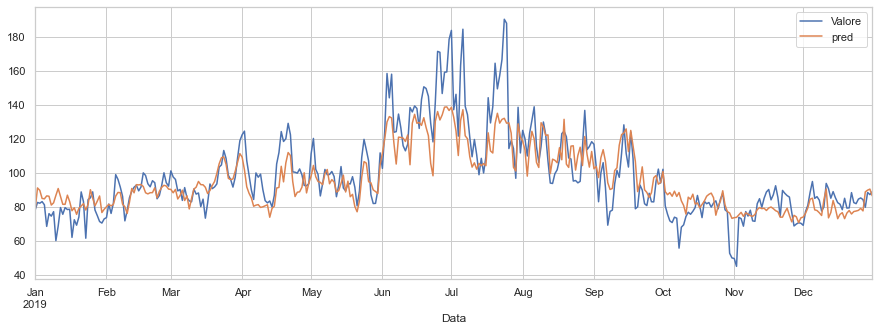

In [2043]:
fig, ax = plt.subplots(figsize=(15, 5))
test_chart_data.plot("Data", "Valore", ax=ax)
test_chart_data.plot("Data", "pred", ax=ax)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-5.0, 105.0)

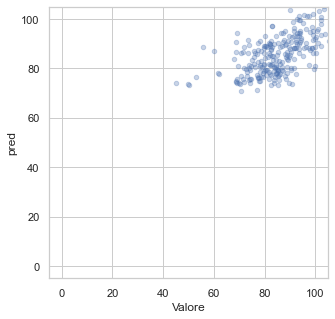

In [2044]:
fig, ax = plt.subplots(figsize=(5, 5))
test_chart_data.plot.scatter("Valore", "pred", alpha=0.3, ax=ax)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 105)

In [2045]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 9.41
Mean squared error: 164.87
Root mean squared error: 12.84


In [2046]:
regressor.score(X_test, y_test)

0.729181531985979

In [2047]:
actual_minus_predicted = sum((y_test - y_pred)**2)
actual_minus_actual_mean = sum((y_test - y_test.mean())**2)
r2 = 1 - actual_minus_predicted/actual_minus_actual_mean
print('R²:', r2)

R²: 0.7291815319859789


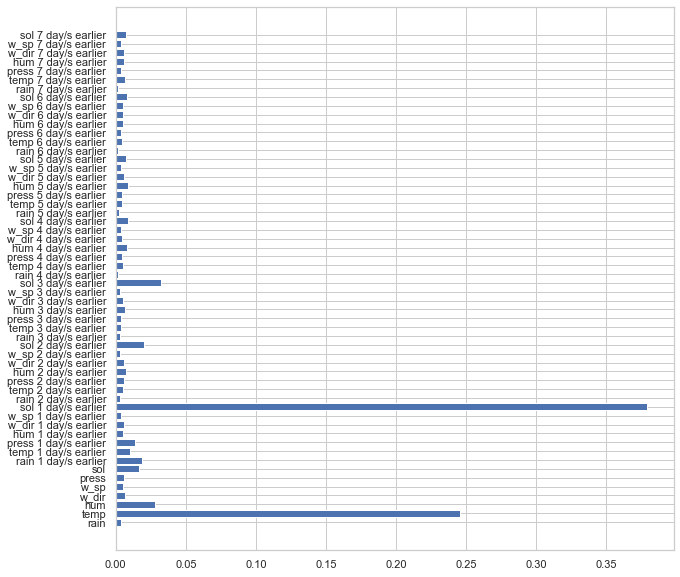

In [2048]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, regressor.feature_importances_)
plt.show()

In [2049]:
input_columns[22]

'temp 3 day/s earlier'

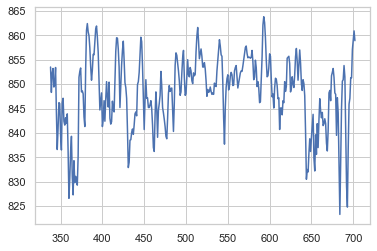

In [2050]:
plt.plot(test_chart_data["press"])

In [2051]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

# Simulazione

In [2052]:
test_chart_data.loc[:, "doy"] = test_chart_data.Data.dt.dayofyear
test_chart_data

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\3115695229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data.loc[:, "doy"] = test_chart_data.Data.dt.dayofyear


,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,w_sp 7 day/s earlier,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier,pred,doy
338,2019-01-01,78.250000,0.0,0.8,mgazza,70.3,325.0,1.5,853.5,5239.6,...,1.7,5069.8,5422.6,5089.1,3463.4,5092.5,5047.5,4049.7,78.676569,1
339,2019-01-02,82.625000,0.0,-2.3,mgazza,46.6,286.0,2.7,848.3,5663.0,...,1.8,5239.6,5069.8,5422.6,5089.1,3463.4,5092.5,5047.5,91.168366,2
340,2019-01-03,82.166667,0.0,-6.7,mgazza,43.4,279.0,3.2,852.3,5533.6,...,1.8,5663.0,5239.6,5069.8,5422.6,5089.1,3463.4,5092.5,89.726036,3
341,2019-01-04,83.125000,0.0,-5.6,mgazza,52.1,282.0,2.0,853.2,5204.7,...,1.8,5533.6,5663.0,5239.6,5069.8,5422.6,5089.1,3463.4,84.995126,4
342,2019-01-05,81.250000,0.0,-0.5,mgazza,61.1,306.0,3.2,849.4,5106.1,...,1.8,5204.7,5533.6,5663.0,5239.6,5069.8,5422.6,5089.1,84.750243,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,2019-12-27,84.291667,0.0,0.0,mgazza,70.2,323.0,1.8,851.3,5314.8,...,2.6,5762.3,5283.3,3410.7,4026.4,824.4,392.7,552.7,77.666528,361
699,2019-12-28,79.791667,0.0,0.1,mgazza,40.7,317.0,3.6,857.1,5421.1,...,1.4,5314.8,5762.3,5283.3,3410.7,4026.4,824.4,392.7,88.849145,362
700,2019-12-29,88.500000,0.0,1.5,mgazza,24.2,319.0,3.4,859.1,5382.5,...,2.3,5421.1,5314.8,5762.3,5283.3,3410.7,4026.4,824.4,89.857992,363
701,2019-12-30,87.250000,0.0,2.7,mgazza,46.9,329.0,1.3,860.9,5218.1,...,2.1,5382.5,5421.1,5314.8,5762.3,5283.3,3410.7,4026.4,90.486667,364


In [2053]:
def get_season(doy):
    if doy < datetime(2022, 3, 21).timetuple().tm_yday:
        return "winter"
    elif doy < datetime(2022, 6, 21).timetuple().tm_yday:
        return "spring"
    elif doy < datetime(2022, 9, 21).timetuple().tm_yday:
        return "summer"
    elif doy < datetime(2022, 12, 21).timetuple().tm_yday:
        return "fall"
    else:
        return "winter"

In [2054]:
test_chart_data["season"] = test_chart_data.doy.map(get_season)

C:\Users\thoma\AppData\Local\Temp\ipykernel_3592\3540010652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chart_data["season"] = test_chart_data.doy.map(get_season)


In [2055]:
input_columns

['rain',
 'temp',
 'hum',
 'w_dir',
 'w_sp',
 'press',
 'sol',
 'rain 1 day/s earlier',
 'temp 1 day/s earlier',
 'press 1 day/s earlier',
 'hum 1 day/s earlier',
 'w_dir 1 day/s earlier',
 'w_sp 1 day/s earlier',
 'sol 1 day/s earlier',
 'rain 2 day/s earlier',
 'temp 2 day/s earlier',
 'press 2 day/s earlier',
 'hum 2 day/s earlier',
 'w_dir 2 day/s earlier',
 'w_sp 2 day/s earlier',
 'sol 2 day/s earlier',
 'rain 3 day/s earlier',
 'temp 3 day/s earlier',
 'press 3 day/s earlier',
 'hum 3 day/s earlier',
 'w_dir 3 day/s earlier',
 'w_sp 3 day/s earlier',
 'sol 3 day/s earlier',
 'rain 4 day/s earlier',
 'temp 4 day/s earlier',
 'press 4 day/s earlier',
 'hum 4 day/s earlier',
 'w_dir 4 day/s earlier',
 'w_sp 4 day/s earlier',
 'sol 4 day/s earlier',
 'rain 5 day/s earlier',
 'temp 5 day/s earlier',
 'press 5 day/s earlier',
 'hum 5 day/s earlier',
 'w_dir 5 day/s earlier',
 'w_sp 5 day/s earlier',
 'sol 5 day/s earlier',
 'rain 6 day/s earlier',
 'temp 6 day/s earlier',
 'press 6 da

In [2056]:
regressor.predict([row_array])[0]  # takes the predicted value


c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


75.43057554292757

In [2057]:
test_chart_data_year

,Data,Valore,rain,temp,Location,hum,w_dir,w_sp,press,sol,...,sol 1 day/s earlier,sol 2 day/s earlier,sol 3 day/s earlier,sol 4 day/s earlier,sol 5 day/s earlier,sol 6 day/s earlier,sol 7 day/s earlier,pred,doy,season
1827,2017-01-01,75.416667,0.0,-2.0,bolz,79.7,330.0,0.6,998.0,5257.6,...,5023.5,4741.5,3165.1,4440.6,4615.7,4394.0,4279.8,82.048769,1,winter
1828,2017-01-02,85.125000,0.0,-1.6,bolz,76.7,345.0,0.7,992.9,5373.3,...,5257.6,5023.5,4741.5,3165.1,4440.6,4615.7,4394.0,80.835832,2,winter
1829,2017-01-03,72.850000,0.0,3.6,bolz,51.6,328.0,2.1,993.4,4947.6,...,5373.3,5257.6,5023.5,4741.5,3165.1,4440.6,4615.7,64.092126,3,winter
1830,2017-01-04,83.416667,0.0,0.3,bolz,57.3,340.0,1.4,985.8,4700.5,...,4947.6,5373.3,5257.6,5023.5,4741.5,3165.1,4440.6,70.362088,4,winter
1831,2017-01-05,17.458333,0.0,3.9,bolz,30.0,4.0,3.8,989.3,4923.4,...,4700.5,4947.6,5373.3,5257.6,5023.5,4741.5,3165.1,24.146085,5,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,74.041667,32.8,1.1,bolz,100.0,348.0,1.1,969.6,253.2,...,3390.3,4760.4,4334.7,3446.1,2762.6,3683.8,4171.0,72.392202,361,winter
2188,2017-12-28,51.772727,4.6,4.0,bolz,73.5,322.0,3.1,966.4,1754.1,...,253.2,3390.3,4760.4,4334.7,3446.1,2762.6,3683.8,43.230412,362,winter
2189,2017-12-29,45.500000,0.0,2.1,bolz,55.9,335.0,2.5,984.0,4742.2,...,1754.1,253.2,3390.3,4760.4,4334.7,3446.1,2762.6,48.139622,363,winter
2190,2017-12-30,52.125000,0.0,-0.3,bolz,74.5,334.0,2.1,990.2,4078.9,...,4742.2,1754.1,253.2,3390.3,4760.4,4334.7,3446.1,58.692052,364,winter


In [2058]:
def run_simulation(
    X,
    simulation_variable, 
    change, 
    change_as_perc,
    need_threshold,
    threshold,
):
    X_simulation = X[input_columns].copy()
    # ['rain','temp','hum','w_dir','w_sp','press','sol']

    simulation_results = {}

    sim_var_columns = X_simulation.columns[
        X_simulation.columns.str.contains(f"^{simulation_variable}")
    ]

    X_simulation_high = X_simulation.copy()
    if change_as_perc:
        X_simulation_high.loc[:, sim_var_columns] *= (1 + change)
    else:
        X_simulation_high.loc[:, sim_var_columns] += change
    if need_threshold:
        X_simulation_high.loc[:, sim_var_columns] = X_simulation_high[sim_var_columns].clip(upper=threshold)


    X_simulation_low = X_simulation.copy()
    if change_as_perc:
        X_simulation_low.loc[:, sim_var_columns] *= (1 - change)
    else:
        X_simulation_low.loc[:, sim_var_columns] -= change

    simulation_results["ref"] = regressor.predict(X_simulation)  # takes the predicted value
    simulation_results["low"] = regressor.predict(X_simulation_low)  # takes the predicted value
    simulation_results["high"] = regressor.predict(X_simulation_high)  # takes the predicted value

    simulation_results = pd.DataFrame(simulation_results)

    return simulation_results

In [2069]:
year = 2019
test_chart_data_year = test_chart_data[test_chart_data.Data.dt.year == year]

exps = [{
    "simulation_variable": "hum",
    "change": 0.05,
    "change_as_perc": True,
    "need_threshold": True,
    "threshold": 100
}, {
    "simulation_variable": "press",
    "change": 10,
    "change_as_perc": False,
    "need_threshold": False,
    "threshold": None
}, {
    "simulation_variable": "rain",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": True,
    "threshold": 1000
}, {
    "simulation_variable": "temp",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": False,
    "threshold": None
}, {
    "simulation_variable": "w_sp",
    "change": 1,
    "change_as_perc": False,
    "need_threshold": True,
    "threshold": 1000
}, {
    "simulation_variable": "sol",
    "change": 0.05,
    "change_as_perc": True,
    "need_threshold": False,
    "threshold": None
}]

simulation_results = {}

for exp in exps:
    simulation_result = run_simulation(
        test_chart_data_year,
        **exp
    )

    print(exp["change"], exp["change_as_perc"])


    simulation_result["season"] = test_chart_data_year.season.values


    simulation_result = (
        simulation_result
        .melt(id_vars=["season"])
        .set_index("variable")
        .loc[["low", "ref", "high"]]
        .reset_index()
    )
    simulation_results[exp["simulation_variable"]] = simulation_result

0.05 True
10 False
1 False
1 False
1 False
0.05 True


In [2088]:
def do_box_plot(param, title, ylab):
    df_box = simulation_results[param].copy()
    df_box = df_box[df_box.season.isin(["winter", "summer"])]

    # Need to find the dict that contains the "param" parameter in the list exps
    exp_needed = None
    for exp in exps:
        if exp["simulation_variable"] == param:
            exp_needed = exp
    
    if exp == None:
        print("------------------------ERROR--------------------------------")

    condition_to_unit = {"rain": "mm", "temp": "°C", "hum": "%", "w_sp": "m/s", "press": "hPa", "sol": "kJ/m2"}
    condition_to_description = {
        "rain": "precipitation",
        "temp": "temperature",
        "hum" : "relative humidity",
        "w_sp": "wind speed",
        "press": "atmospheric pressure",
        "sol": "solar radiation"
    }

    low_value = f'-{int(float(exp_needed["change"])*100) if exp_needed["change_as_perc"] else exp_needed["change"]}{"%" if exp_needed["change_as_perc"] else ""} {condition_to_unit[exp_needed["simulation_variable"]]}'
    reference = "Reference"
    high_value = f'+{int(float(exp_needed["change"])*100) if exp_needed["change_as_perc"] else exp_needed["change"]}{"%" if exp_needed["change_as_perc"] else ""} {condition_to_unit[exp_needed["simulation_variable"]]}'
    
    df_box["variable"] = df_box.variable.map({
        "low": low_value, 
        "ref": reference,
        "high": high_value
    })

    df_box = df_box.rename({"variable": "Values"}, axis=1)

    ax = sns.boxplot(
        x="season",
        y="value",
        hue="Values",
        data=df_box
    )

    ax.set_title(title)
    ax.set_xlabel("Average " + condition_to_description[param])
    ax.set_ylabel(ylab + " (μg/m3)")


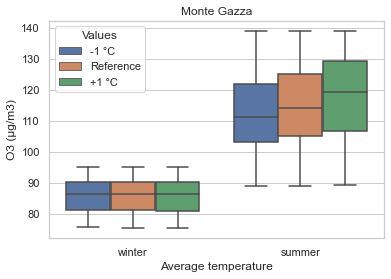

In [2091]:
do_box_plot("temp", "Monte Gazza", "O3")

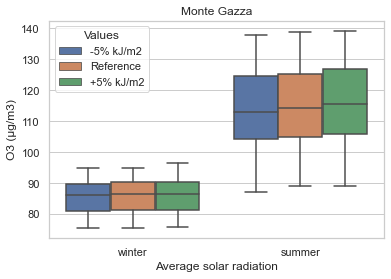

In [2093]:
do_box_plot("sol", "Monte Gazza", "O3")